# Reinforcement Learning Trading Environment

Trying out **policy iteration** to **Q-learning** for the first time using a realistic market simulator.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from trading_env import MarketSimConfig, TradingMarketEnv, rollout_episode
from rl_starters import (
    ToyTradingMDP,
    policy_iteration,
    td0_policy_evaluation,
    mc_policy_evaluation,
    UniformDiscretizer,
    q_learning_tabular,
)

In [2]:
config = MarketSimConfig(
    episode_length=400,
    lookback=32,
    max_position=1.0,
    risk_aversion=0.02,
    seed=42,
)
env = TradingMarketEnv(config)

print('Action space:', env.action_space.n, '(0=short,1=flat,2=long)')
print('Observation shape:', env.observation_space.shape)

Action space: 3 (0=short,1=flat,2=long)
Observation shape: (37,)


In [3]:
summary = rollout_episode(env)
summary

{'steps': 399,
 'reward_sum': -0.29286614938992184,
 'reward_mean': -0.0007340003744108317,
 'final_portfolio': 0.7941305584794174,
 'max_portfolio': 1.037041506613582,
 'min_portfolio': 0.7452428645185194}

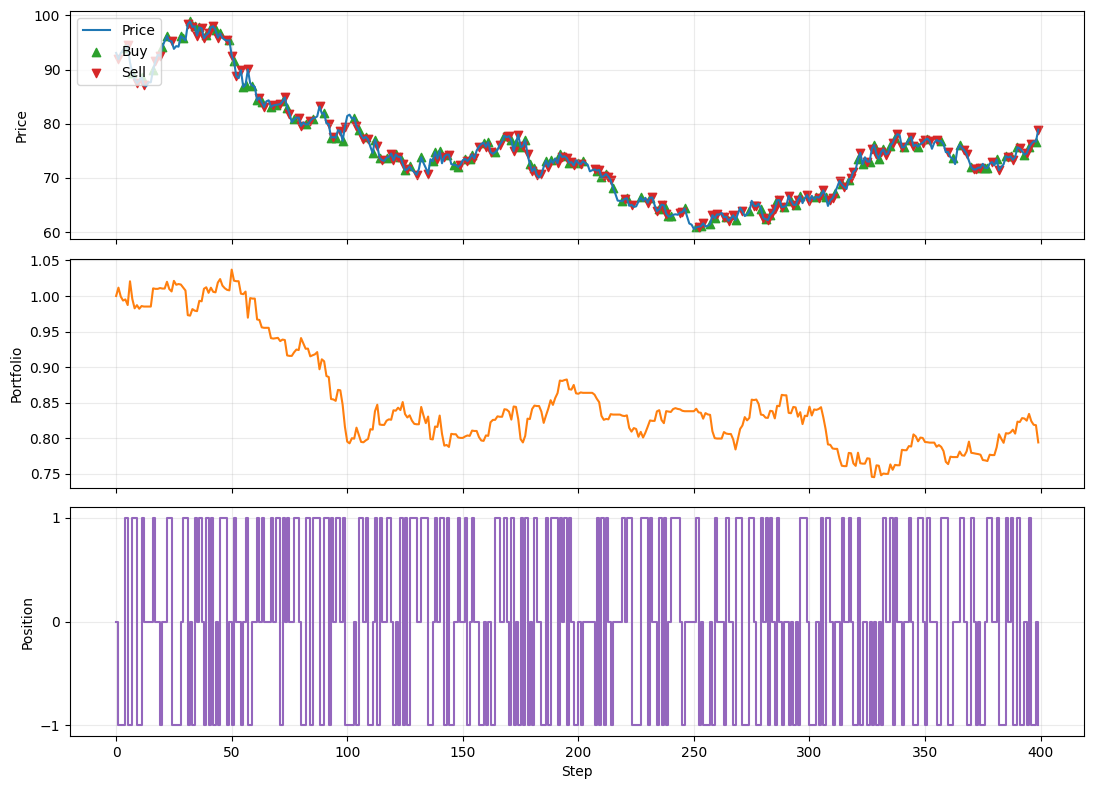

In [4]:
fig = env.render(mode='notebook')
plt.show()

## 1) Policy Iteration (Toy MDP)
Start with a tiny model-based market MDP so dynamic programming is easy to understand.

In [5]:
mdp = ToyTradingMDP(gamma=0.95)
policy, V_star = policy_iteration(mdp)

action_names = ['short', 'flat', 'long']
state_names = ['bear', 'sideways', 'bull']
for s, name in enumerate(state_names):
    print(name, '->', action_names[policy[s]], 'V*=', round(float(V_star[s]), 6))

bear -> short V*= 0.032967
sideways -> flat V*= 0.028536
bull -> long V*= 0.03245


## 2) TD(0) and Monte Carlo Evaluation (Toy MDP)

In [6]:
V_td = td0_policy_evaluation(mdp, policy, episodes=5000, alpha=0.05, rng_seed=0)
V_mc = mc_policy_evaluation(mdp, policy, episodes=5000, rng_seed=0)

print('V*   :', np.round(V_star, 5))
print('TD(0):', np.round(V_td, 5))
print('MC   :', np.round(V_mc, 5))

V*   : [0.03297 0.02854 0.03245]
TD(0): [0.03289 0.02799 0.03213]
MC   : [0.00716 0.00592 0.00891]


## 3) Tabular Q-learning on Realistic Market Environment

In [7]:
obs_low = np.full(env.observation_space.shape[0], -0.08, dtype=np.float32)
obs_high = np.full(env.observation_space.shape[0], 0.08, dtype=np.float32)
# Last features have different scale
obs_low[-2:] = np.array([0.0, -1.0], dtype=np.float32)
obs_high[-2:] = np.array([1.0, 1.0], dtype=np.float32)

disc = UniformDiscretizer(obs_low, obs_high, bins=6)
q_table, rewards = q_learning_tabular(
    env,
    discretizer=disc,
    episodes=400,
    alpha=0.08,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    rng_seed=7,
)

print('Q-table states learned:', len(q_table))
print('Last 20-episode mean reward:', float(np.mean(rewards[-20:])))

Q-table states learned: 115737
Last 20-episode mean reward: -0.2967038098893722


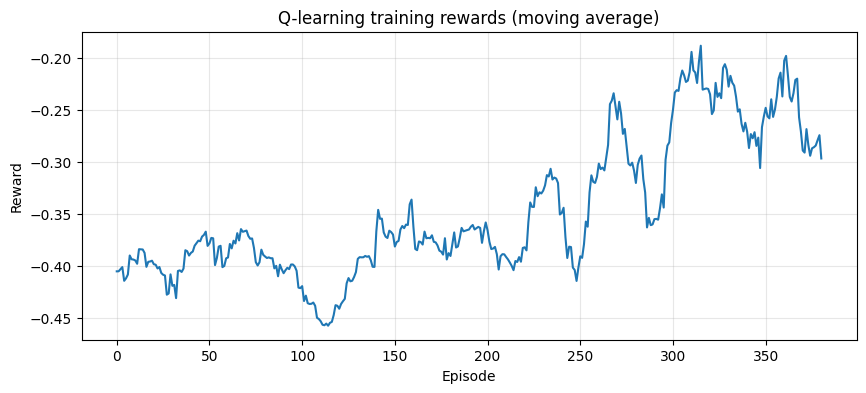

In [8]:
plt.figure(figsize=(10, 4))
window = 20
smoothed = np.convolve(rewards, np.ones(window) / window, mode='valid')
plt.plot(smoothed)
plt.title('Q-learning training rewards (moving average)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(alpha=0.3)
plt.show()